# Titanic data
### This is my first project to get familier with kaggle. 
<br>
Sinking of titanic was one of the most infamous and tragedic events in history. The goal of this project is to predict wheather a passanger will survive this incident based on the details provided in the dataset.

In [2]:
#load data
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from functon_scripts.col_names import col_names, namedict
from functon_scripts.SpecialImputers import ImputeAge, ImputeFare
from functon_scripts.CustomEstimators import CabinImputer, EmbarkedImputer, DoNothing, DropColumns, FareCat
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

data_dir = 'data/'

data = pd.read_csv(data_dir + 'train.csv')
d1 = data.copy()
labels = data['Survived']
data = data.drop('Survived', axis=1)
testdata = pd.read_csv(data_dir + 'test.csv')
data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [48]:
print(f'train shape: {data.shape}')
print(f'test shape: {testdata.shape}')
print(data.columns)

train shape: (891, 11)
test shape: (418, 11)
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


So the dataset consists of 891 rows and 11 columns. That means I have details about 891 passengers about the above mentioned features.
<br><br>
The variables **PassengerId**, **Survived**, **Name**, **Sex**, **Age**, **Ticket**, **Fare** are self explanatory.
<br><br>
**Pclass** : Ticket class, this explains quality of living <br>
**SibSp** : Number of sibling or spouse aboard <br>
**Parch** : Number of parents or children aboard <br>
**Embark** : Port of Embarkation

Now, we need to check wheather there are nan values in the dataset. i.e. If some parts of the data are missing or not. 

In [51]:
# check which columns contain nan values
from functon_scripts.find_nan_cols import find_nan_cols

find_nan_cols(data)
find_nan_cols(testdata)

{'Age': 177, 'Embarked': 2}
{'Age': 86, 'Fare': 1, 'Cabin': 327}


* Out of 891 rows in training set we have 687 nan values in `Cabin`. And out of 418 rows in test set we have 327 missing values. I think only 104 rows in 891 rows will not give sufficient information to infer about anything.
* The number of missing values in `Age` is also large. But Age could be a very useful variable to predict survival capability of any person.
* Only 2 missing values in `Embarked` in the training set, when there is no missing value of the same in the test set.
* We have a new feature with missing values in the test set, although there is only one missing value. To generalize our model, we also need to figure out a way to impute `Fare` also 

In [49]:
# Impute Cabin nan values with Z, and extract the first letter from each cabin number
data.Cabin = CabinImputer(imp="Z").fit_transform(data[['Cabin']].to_numpy())

People living together can be figured out by extracting their cabin number as well as ticket number. The type of Cabin (eg. C, D, G, etc.) can give some hint about the location of the cabin which in turn may hint about survival of the families. Firstly, we want to see if at all the Cabin feature hints anything about survival of the passengers.

In [50]:
pd.crosstab(labels, data.Cabin, rownames=['labels'], colnames=['Cabin'])

Cabin,A,B,C,D,E,F,G,T,Z
labels,,,,,,,,,
0,8,12,24,8,8,5,2,1,481
1,7,35,35,25,24,8,2,0,206


Here we can see that people living in cabin B, D, E has very high probability of surviving. Note that Z denotes missing value in the data, so I shall have to deal with those corresponding passengers differently

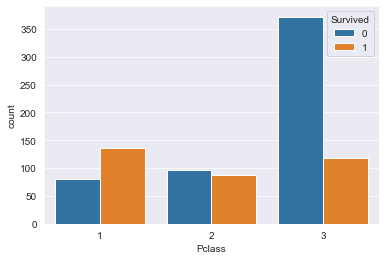

In [56]:
_ = sns.countplot(data=data, x='Pclass', hue=labels)

So people in class 1 has higher chance of surviving whereas people in class 3 are less probable to survive.

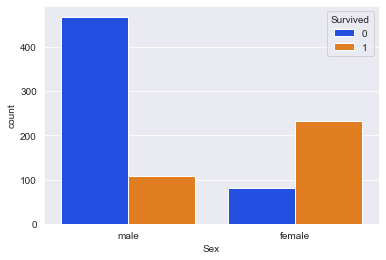

In [78]:
_ = sns.countplot(data=data, x='Sex', hue=labels)

Well that's not really surprising is it? Atleast from the movie you can tell that men very much liked to sacrifice their lives to save their fellow female passengers :D.<br>
### It turns out that the real challenge lies in detecting a male surviver and a female casualty.

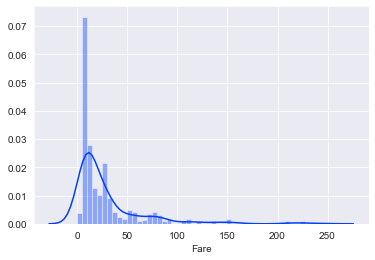

In [77]:
sns.set_palette('bright')
_ = sns.distplot(data.Fare[data.Fare<250], kde=True)
sns.palette

So you can see most of the Fares lie on the interval (0, 50) more specifically (5, 15). The cost of the fare may decide the ablity of surviving. To check this, we shall discretize the values of Fare by putting each of the values in some carefully created classes say {(-1, 5), (5, 10), (10, 35), (35, 100), (100, 250), (250, inf)}. This bins/classes need to be created in such a way, inference about survival becomes most precise. Notice that I put a -1 as the class boundary of the first class, because there are a few people who have boarded the ship free of cost! Hence I created a class with people with really low fare.


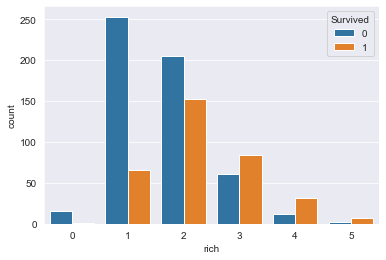

In [3]:
from functon_scripts.SpecialImputers import DiscreteFare

data['rich'] = DiscreteFare().fit_transform(d1[['Fare']])
_ = sns.countplot(x='rich', hue=labels, data=data)

Evidently, the richer a person is, more is the probablity of him surviving the disaster. The counts shown in the above plot will depend on the class boundaries. But I think my current choice is decent.

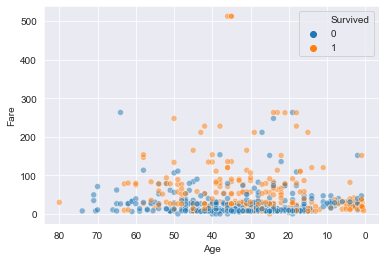

In [64]:
# TODO: Need to discretize Fare first
_ = sns.scatterplot(data=data, x='Age', y='Fare', hue=labels, alpha=0.5)
_.invert_xaxis()

In [26]:
data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Z,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Z,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Z,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,Z,S
887,888,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B,S
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,Z,S
889,890,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C,C


### Note:
We need to find ways to impute 'Age' and 'Fare' <br>
I dont think 'Embarked' is at all important <br>
'Cabin' can be converted into categorical (? maybe? need to check)

In [28]:
# if there is any Pclass that has non null values of cabin
print(data.Pclass[data.Cabin.isnull()].unique())

[]


In [ ]:
print(f'unique_cabin : {data.Cabin.unique().shape}\ntotal_Cabin_nan : {sum(data.Cabin.isnull())}')

### Note2:
After imputing 'Age' and 'Fare', the list of explanatory variables becomes <br>
{id, Pclass, sex, age, sibsp, parch, fare, cabin}

using sibsp and parch can be tricky, maybe i need to form separate model for those, to provide probability of surviving, when you have extra family member

### Note3:
I think number of siblings or parents/children can defintely tell something about the age group of a person. The remaining variables that make a little to no sense are {Pclass, sex, Fare}

In [31]:
data['ticketno']

KeyError: 'ticketno'

# Create Pipelines

-- Drop Name, Ticket + add fam_n_frnd ;; Impute, categorize Cabin and Embarked <br>
-- One hot encode Cabin, Embarked, Sex, Pclass <br>
-- Create ordinal fare group {note that we can only group the data in training set}<br>
-- Impute ordinal fare {transformation will be tricky as it contains NaN values}<br>
-- impute Age <br>
====== thus cleaning is done
-- finally fit xgboost, svm and knn and use hard voting

In [32]:
cols = data.columns.drop(['Cabin', 'Embarked'])
imputer_1 = ColumnTransformer([
    ('drp', DropColumns(drop_ix=[0, 2, 7], features=cols), cols),
    ('cabin_imp', CabinImputer(), ['Cabin']),
    ('Emb_imp', EmbarkedImputer(strategy='most_frequent'), ['Embarked'])
])

ohe_categories = [np.array([1, 2, 3], dtype=object),
                np.array(['female', 'male'], dtype=object),
                np.array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'Z'], dtype=object),
                np.array(['C', 'Q', 'S'], dtype=object)]
                # had to fit a model and get the categories
ohe_cols = [0, 1, 6, 7]
nthn_cols = [2, 3, 4]
imputer_2 = ColumnTransformer([
    ('ohe', OneHotEncoder(categories=ohe_categories), ohe_cols),
    ('nthn', DoNothing(), nthn_cols),
    ('farecut', FareCat(), [5])
])

half_pipeline = Pipeline([
    ('imp1', imputer_1),
    ('imp2', imputer_2),
])

X = half_pipeline.fit_transform(data)
X = pd.DataFrame(X)
X.columns = imputer_2.get_feature_names()
X.head()

,ohe__x0_1,ohe__x0_2,ohe__x0_3,ohe__x1_female,ohe__x1_male,ohe__x2_A,ohe__x2_B,ohe__x2_C,ohe__x2_D,ohe__x2_E,...,ohe__x2_G,ohe__x2_T,ohe__x2_Z,ohe__x3_C,ohe__x3_Q,ohe__x3_S,nthn__Age,nthn__SibSp,nthn__Parch,farecut__Fare
0,0,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,1,22,1,0,1
1,1,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,38,1,0,3
2,0,0,1,1,0,0,0,0,0,0,...,0,0,1,0,0,1,26,0,0,1
3,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,1,35,1,0,3
4,0,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,1,35,0,0,1


### Pipeline: (conitinued)
Imputing Fare and Age

### Final Cleaning Pipeline

In [33]:
cleaning_pipeline = Pipeline([
    ('imp1', imputer_1),
    ('imp2', imputer_2),
    ('fare_imp', ImputeFare()),
    ('age_imp', ImputeAge()),
])

X = cleaning_pipeline.fit_transform(data)
X_test = cleaning_pipeline.transform(testdata)

X = pd.DataFrame(X.astype(float))
X.columns = col_names(features=namedict.keys())
sum(np.isnan(X_test.astype(float)))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Note9:
Finally cleaning is done. Need to create separate classifiers now and apply hard voting

In [34]:
#xgb model

param_grid = [
    {'n_estimators': np.arange(20, 90, step=10),
     'max_depth': [2, 3, 4],
     'max_leaf_nodes': [3, 4, 5, 6]
    },
]

grids_xgb = GridSearchCV(XGBClassifier(), param_grid, scoring="accuracy", return_train_score=True, cv=8)
grids_xgb.fit(X, labels)

joblib.dump(grids_xgb.best_estimator_, 'full_xgb_best.pkl')
grids_xgb.best_params_

NameError: name 'XGBClassifier' is not defined

In [35]:
from xgboost import plot_importance

plot_importance(grids_xgb.best_estimator_)
print(grids_xgb.best_score_)

NameError: name 'grids_xgb' is not defined

In [36]:
from sklearn.metrics import roc_auc_score

roc_auc_score(labels, grids_xgb.best_estimator_.predict(X))

NameError: name 'grids_xgb' is not defined

In [37]:
#logistic regression
param_grid = [
    {'C': np.arange(0.3, 0.8, step=0.05)}
]

grids_lgst = GridSearchCV(LogisticRegression(penalty='l1', solver='liblinear'), param_grid, scoring="accuracy", return_train_score=True, cv=5)
grids_lgst.fit(X, labels)

joblib.dump(grids_lgst.best_estimator_, 'full_logst_best.pkl')
grids_lgst.best_params_

{'C': 0.44999999999999996}

In [38]:
print(f'f1 = {grids_lgst.best_score_}')
print(f'auc = {roc_auc_score(labels, grids_lgst.best_estimator_.predict(X))}')

f1 = 0.7968551879982424
auc = 0.7860464001533889


In [39]:
# KNN
param_grid = [
    {'n_neighbors': np.arange(3, 10, step=1)}
]

grids_knn = GridSearchCV(KNeighborsClassifier(), param_grid, scoring="accuracy", return_train_score=True, cv=5)
grids_knn.fit(X, labels)

joblib.dump(grids_knn.best_estimator_, 'full_knn_best.pkl')
grids_knn.best_params_

{'n_neighbors': 5}

In [40]:
print(f'f1 = {grids_knn.best_score_}')
print(f'auc = {roc_auc_score(labels, grids_knn.best_estimator_.predict(X))}')

f1 = 0.8069738246186681
auc = 0.8506375227686703


### Note10:
Hence three different classifier has been trained. We see that knn is performing better than logistic regression. We can still do pca and then apply all these algorithms. There is lot to improve like visualising the non linearity.. I think that's why logistic regression did not perform well.

## Hard Voting

{'max_depth': 3, 'max_leaf_nodes': 3, 'n_estimators': 90} <br>
{'C': 0.44999999999999996} <br>
{'n_neighbors': 5}

In [41]:
from sklearn.ensemble import VotingClassifier

final_classifier = VotingClassifier([
    ('xgb', XGBClassifier(max_depth=2, max_leaf_nodes=3, n_estimators=50)),
    ('lgst', LogisticRegression(C=0.45)),
    ('knn', KNeighborsClassifier(n_neighbors=5))
], voting='hard')

full_pipeline = Pipeline([
    ('clean', cleaning_pipeline),
    ('estimate', final_classifier)
])

model_1 = full_pipeline.fit(data, labels)
model_1.predict(testdata)

NameError: name 'XGBClassifier' is not defined

In [42]:
scores = cross_val_score(model_1, data, labels, cv=7, scoring='accuracy')
scores

NameError: name 'model_1' is not defined

In [43]:
submit = testdata.PassengerId.to_frame()
submit['Survived'] = pd.Series(model_1.predict(testdata), dtype=object)

NameError: name 'model_1' is not defined

In [44]:
submit.head()

,PassengerId
0,892
1,893
2,894
3,895
4,896


In [45]:
submit.to_csv(data_dir + 'submission_accuracy.csv', index=False)

In [84]:
sum(data.Fare > 250)

9